In [1]:
import pyemu
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import sys
sys.path.insert(1, '../../modules')
# import modules
from Rouss import *
from Rouss3D import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
t_d ="master_glm"
case = "3D_test"
pst = pyemu.Pst(os.path.join(t_d,"{}.pst".format(case)))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cond,cond,log,6,-3 to -2,-2,-3,0.25
ep__multiplier,ep__multiplier,log,1,1,1,-1,0.5
irr__multiplier,irr__multiplier,log,14,-0.09691 to 0.30103,0.30103,-0.09691,0.099485
kp_pc_inst:0,kp_pc_inst:0,log,293,-1 to 1.47712,1.47712,-1,0.61928
kp_q_inst:0,kp_q_inst:0,log,224,-2.30103 to 0.69897,0.69897,-2.30103,0.75
pms__multiplier,pms__multiplier,log,1,-1,1.47712,-1,0.61928


[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

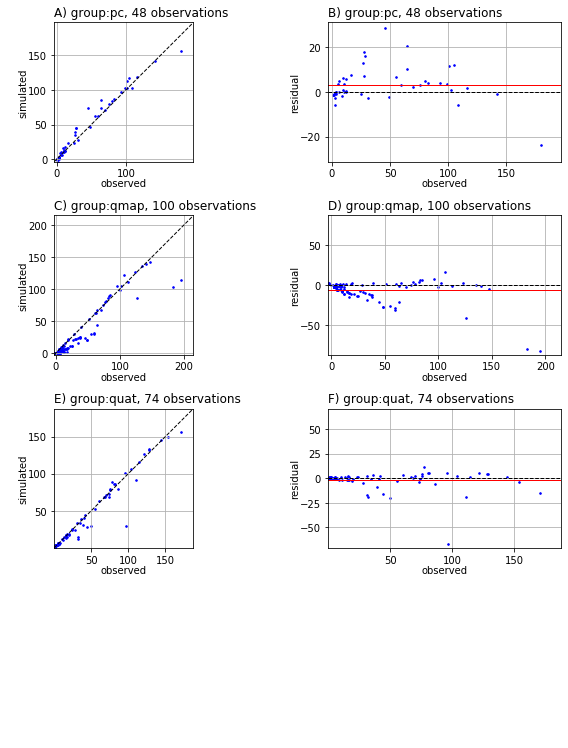

In [3]:
pst.plot(kind='1to1')

In [18]:
pst.svd_data.eigthresh = 5e-7
pst.control_data.noptmax = 7 # number of iterations (should be set to a great value (50))
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 4
pst.pestpp_options["glm_num_reals"] = 50 # how many draws
pst.pestpp_options["parcov"] = "{}.prior.cov".format(case)
pst.pestpp_options["base_jacobian"] = "{}.jcb".format(case)
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:7, npar_adj:215, nnz_obs:222


In [19]:
# DO the inversion
m_d = "master_glm_run"
pyemu.os_utils.start_workers(t_d,"../../pestpp-glm.exe","{}.pst".format(case),num_workers=8,worker_root=".",
                             master_dir=m_d)

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

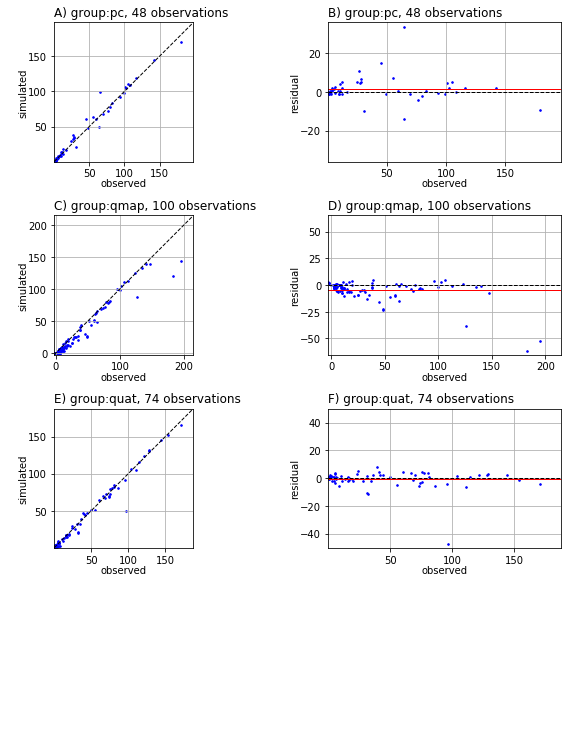

In [7]:
m_d = "master_glm_run"
pst_2 = pyemu.Pst(os.path.join(m_d,"{}.pst".format(case)))
pst_2.plot(kind="1to1")

8097.86661200474 {'pc': 2193.9436383087623, 'qmap': 2864.8013000852466, 'quat': 3039.1216736107303} {'pc': 0.2709285968055259, 'qmap': 0.35377234984808237, 'quat': 0.3752990533463916}


[None,
 None,

<Figure size 576x756 with 0 Axes>

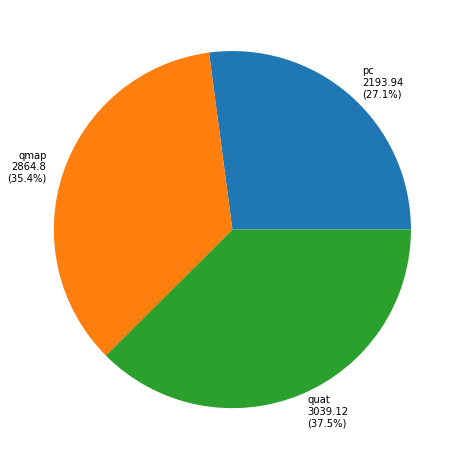

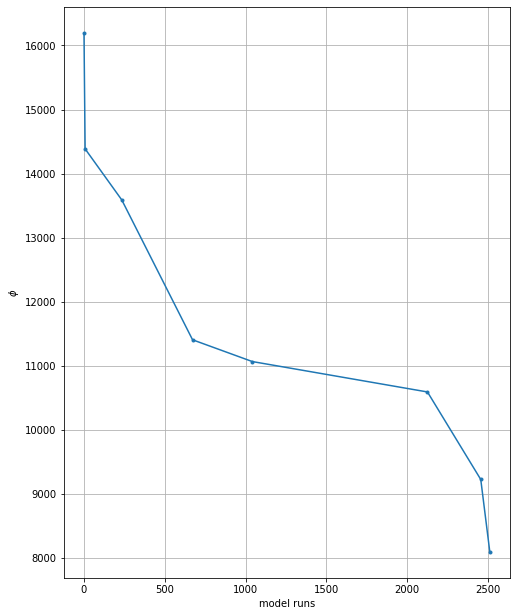

In [5]:
pst_2.plot()

C:\Users\emmal\Anaconda3\lib\site-packages\pyemu\en.py:365: UserWarning: Ensemble.from_dataframe() is deprecated and has been replaced with the standard constructor, which takesthe same arguments
  warnings.warn("Ensemble.from_dataframe() is deprecated and has been "


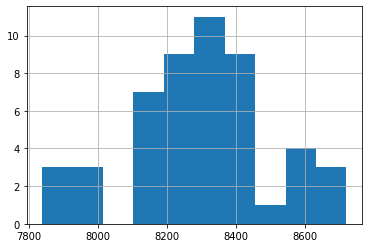

In [6]:
df = df=pd.read_csv(os.path.join(m_d,"{}.post.obsen.csv".format(case)),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

ax = oe.phi_vector.hist()

In [7]:
dfp = df=pd.read_csv(os.path.join(m_d,"{}.par.usum.csv".format(case)),index_col=0)
dfp["post_mean"]

name
KP_Q_INST:0_I:15_J:135             0.69897
KP_Q_INST:0_I:21_J:135            -2.30103
KP_Q_INST:0_I:27_J:123             0.69897
KP_Q_INST:0_I:27_J:129             0.69897
KP_Q_INST:0_I:27_J:135            -2.30103
                                    ...   
MULTIPLIER_IRR_INST:0_ZONE:5.0     0.30103
MULTIPLIER_IRR_INST:0_ZONE:11.0    0.30103
MULTIPLIER_IRR_INST:0_ZONE:6.0     0.30103
MULTIPLIER_CONST_EP_INST:0         1.00000
MULTIPLIER_CONST_PMS_INST:0       -1.00000
Name: post_mean, Length: 539, dtype: float64

(array([147.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 145.]),
 array([-1.      , -0.752288, -0.504576, -0.256864, -0.009152,  0.23856 ,
         0.486272,  0.733984,  0.981696,  1.229408,  1.47712 ]),
 <a list of 10 Patch objects>)

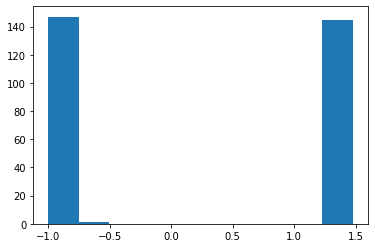

In [18]:
idx_kpq = [i for i in range(dfp.shape[0]) if "KP_PC" in dfp.index[i]]
plt.hist(dfp.reset_index().loc[idx_kpq]["post_mean"])

In [9]:
pst_2.parameter_data.parval1 = 10**dfp["post_mean"].values
pst_2.control_data.noptmax = 0 # one run

pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)

noptmax:0, npar_adj:539, nnz_obs:222


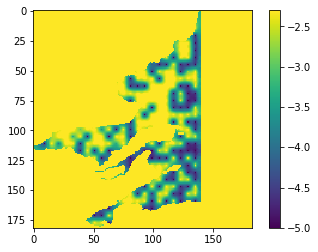

In [10]:
# inversion
plt.imshow(np.log10(np.loadtxt(os.path.join(t_d,"kq.txt"))))
plt.colorbar()

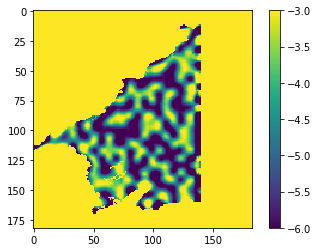

In [3]:
# inversion
plt.imshow(np.log10(np.loadtxt(os.path.join(t_d,"kpc.txt"))))
plt.colorbar()

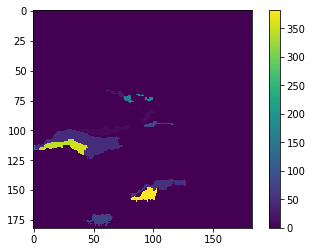

In [6]:
plt.imshow((1000*86400*365*np.loadtxt(os.path.join(t_d,"irr.txt"))))
plt.colorbar()

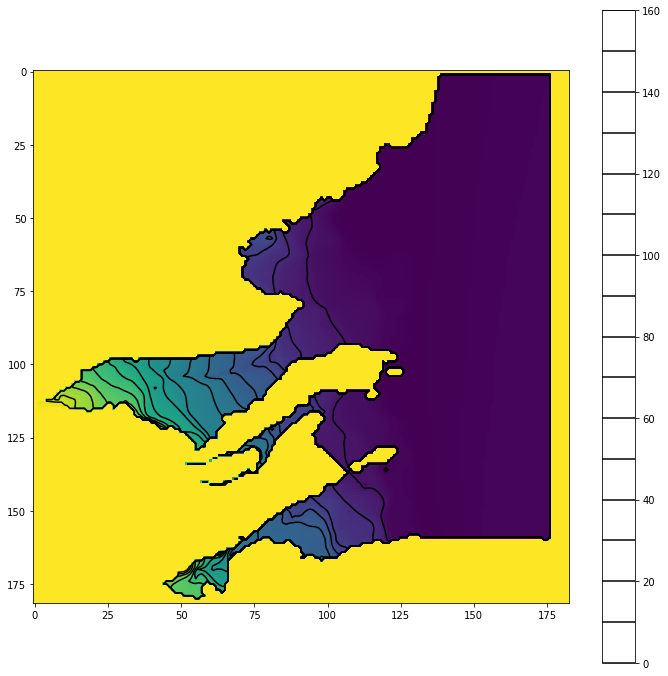

In [21]:
fig,ax = plt.subplots(figsize=(12,12))

layer = 1

head = get_heads("PEST_3D_R","master_glm")
plt.imshow(head[layer],vmin=0,vmax=170)
cont = plt.contour(head[layer],colors="k",levels=np.arange(0,170,10))
plt.colorbar()

In [14]:
top,botm,idomain,delr,delc = read_pickle(os.path.join("workspace","export_dis3D"))

In [15]:
#control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using ImportControlPz3D (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
geol_layer = ["Quaternaire","Pliocène"]
geol_col = "AquifèreCapté"
grid = fp.discretization.StructuredGrid(delc,delr,xoff =664525 ,yoff =6152875 )
nlay=5
Control_Pz = ImportControlPz3D(piez_path,sheet_name="2012",geol_layer=geol_layer,layer_num=[1,3],geol_col=geol_col,
                               grid=grid,nlay=nlay,np_col = "NP_Avril2013")

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [16]:
nrow=idomain.shape[1]
ncol=idomain.shape[2]

Misfit : 3.304557130258784 m 
MSE    : 42.89398698149553
φ      : 5233.066411742455


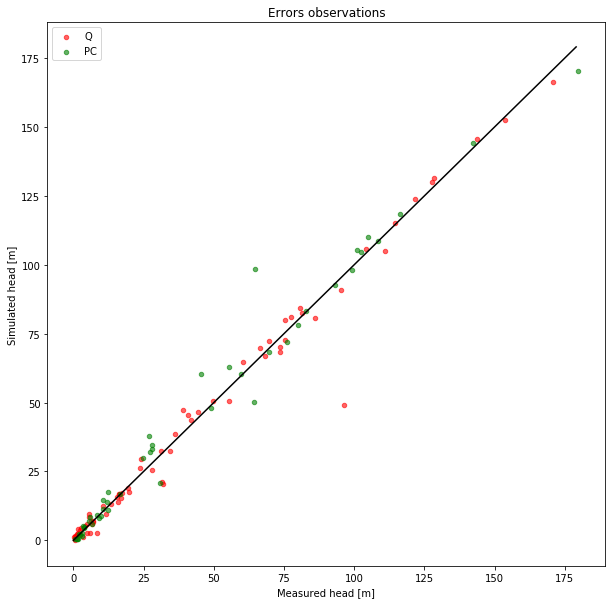

In [17]:
color = ["y","red","blue","green","black"]
label = ["sea","Q","inter","PC","PMS"]
fig = plt.figure(figsize=(10,10))

for ilay in [1,3]:
    Control_pz = Control_Pz[ilay].reshape(nrow*ncol)
    head_c = head[ilay].reshape(nrow*ncol)
    
    head_c[head_c>1000]=None
    if (Control_pz!=0).any():
        plt.scatter(Control_pz[Control_pz!=0],head_c[Control_pz!=0],s=20,c=color[ilay],label=label[ilay],alpha=0.6)
plt.legend()
plt.plot(np.arange(180),np.arange(180),"k")
plt.xlabel("Measured head [m]")
plt.ylabel("Simulated head [m]")
plt.title("Errors observations")

# stats
Control_pz = Control_Pz.reshape(nlay*nrow*ncol)
head_2 = head.reshape(nlay*nrow*ncol)
Misfit = np.abs((Control_pz[Control_pz!=0] - head_2[Control_pz!=0]))
MSE = np.nanmean((Control_pz[Control_pz!=0] - head_2[Control_pz!=0])**2)
phi = np.nansum((Control_pz[Control_pz!=0] - head_2[Control_pz!=0])**2)
print("Misfit : {} m ".format(np.nanmean(Misfit)))
print("MSE    : {}".format(MSE))
print("\u03C6      : {}".format(phi))